In [1]:
# Some boilerplate, loading Lasagne and other stuff

import numpy as np
import matplotlib.pyplot as plt
from math import *
%pylab inline

import theano
import theano.tensor as T

from lasagne.utils import floatX

import matplotlib
import matplotlib.pyplot as plt

import lasagne
from lasagne.layers import batch_norm
import sys
import os

from PIL import Image
import scipy
    
np.random.seed(30)

def leakyReLU(x):
    return T.maximum(x,0.2*x)

def invertNL(x):
    return -x

`%matplotlib` prevents importing * from pylab and numpy
Using gpu device 0: GeForce GTX880M (CNMeM is disabled, cuDNN not available)

Populating the interactive namespace from numpy and matplotlib
Couldn't import dot_parser, loading of dot files will not be possible.


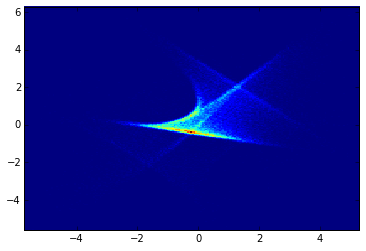

In [2]:
DIM = 2

def sample():
    z1 = np.random.randn()
    z2 = np.random.randn()
    z3 = np.random.randn()
    z4 = np.random.randn()
    
    return np.array([(z1+z2)*cos(z2*(1-z2))+0.05*z3, (z1+2)*sin((z2-0.5)*(z2+0.5))+0.05*z4])

# Make a bunch of samples to visualize the distribution
train = np.zeros( (100000,DIM))
for i in range(train.shape[0]):
    train[i] = sample()

plt.hist2d(train[:,0],train[:,1],200)
plt.show()

In [3]:
# Define the GAN

invar1 = T.matrix()
invar2 = T.matrix()
target = T.ivector()

# Number of variables in the latent space
CONTROLDIM = 4

# Generator layer sizes
N0 = 8
N1 = 8
N2 = 8
N3 = 8
N4 = 8

# Discriminator layer sizes
D1 = 64
D2 = 64
D3 = 64
D4 = 64

def build_model():
    net = {}

    # Generator
    
    net["gen_input"] = lasagne.layers.InputLayer(shape=(None,CONTROLDIM), input_var = invar1 )

    net["gen_layer1"] = lasagne.layers.DenseLayer(incoming = net["gen_input"], num_units = N0, nonlinearity = leakyReLU)
    net["gen_layer2"] = lasagne.layers.DenseLayer(incoming = net["gen_layer1"], num_units = N1, nonlinearity = leakyReLU)
    net["gen_layer3"] = lasagne.layers.DenseLayer(incoming = net["gen_layer2"], num_units = N2, nonlinearity = leakyReLU)
    net["gen_layer4"] = lasagne.layers.DenseLayer(incoming = net["gen_layer3"], num_units = N3, nonlinearity = leakyReLU)
    net["gen_layer5"] = lasagne.layers.DenseLayer(incoming = net["gen_layer4"], num_units = N4, nonlinearity = leakyReLU)

    net["gen_dcg_out"] = lasagne.layers.DenseLayer(incoming = net["gen_layer5"], num_units = DIM, nonlinearity = None)
    
    # Discriminator 
    # This is the version that receives input from the generator
    net["inline_disc_1"] = lasagne.layers.DenseLayer(incoming = net["gen_dcg_out"], num_units = D1, nonlinearity = leakyReLU)
    net["inline_disc_2"] = lasagne.layers.DenseLayer(incoming = net["inline_disc_1"], num_units = D2, nonlinearity = leakyReLU)
    net["inline_disc_3"] = lasagne.layers.DenseLayer(incoming = net["inline_disc_2"], num_units = D3, nonlinearity = leakyReLU)
    net["inline_disc_4"] = lasagne.layers.DenseLayer(incoming = net["inline_disc_3"], num_units = D4, nonlinearity = leakyReLU)
    net["inline_disc_output"] = lasagne.layers.DenseLayer(incoming = net["inline_disc_4"], num_units = 2, nonlinearity = lasagne.nonlinearities.softmax)
    
    # We need to make a separate copy of the network template so that we can feed it an input that isn't coming from the generator.
    # All the weights are shared, so when we train one, we train the other too - its really all the same network
    net["disc_input"] = lasagne.layers.InputLayer(shape=(None,DIM), input_var = invar2 )
    net["disc_1"] = lasagne.layers.DenseLayer(incoming = net["disc_input"], num_units = D1, nonlinearity = leakyReLU, W = net["inline_disc_1"].W, b = net["inline_disc_1"].b)
    net["disc_2"] = lasagne.layers.DenseLayer(incoming = net["disc_1"], num_units = D2, nonlinearity = leakyReLU, W = net["inline_disc_2"].W, b = net["inline_disc_2"].b)
    net["disc_3"] = lasagne.layers.DenseLayer(incoming = net["disc_2"], num_units = D3, nonlinearity = leakyReLU, W = net["inline_disc_3"].W, b = net["inline_disc_3"].b)
    net["disc_4"] = lasagne.layers.DenseLayer(incoming = net["disc_3"], num_units = D4, nonlinearity = leakyReLU, W = net["inline_disc_4"].W, b = net["inline_disc_4"].b)
    net["disc_output"] = lasagne.layers.DenseLayer(incoming = net["disc_4"], num_units = 2, nonlinearity = lasagne.nonlinearities.softmax, W = net["inline_disc_output"].W, b = net["inline_disc_output"].b)

    net["inl_gen"], net["inl_disc"] = lasagne.layers.get_output( (net["gen_dcg_out"], net["inline_disc_output"]) )
    net["ofl_disc"] = lasagne.layers.get_output( (net["disc_output"]) )

    net["gan_params"] = lasagne.layers.get_all_params( net["gen_dcg_out"], trainable = True)
    net["disc_params"] = lasagne.layers.get_all_params( net["disc_output"], trainable = True)

    net["gen_loss"] = T.mean(-T.log(net["inl_disc"][:,1]+1e-16))
    net["disc_loss"] = lasagne.objectives.categorical_crossentropy(net["ofl_disc"],target).mean()

    net["updates_gen"] = lasagne.updates.adam(net["gen_loss"], net["gan_params"], learning_rate = 5e-4, beta1=0.5)
    net["updates_disc"] = lasagne.updates.adam(net["disc_loss"], net["disc_params"], learning_rate = 1e-3, beta1 = 0.5)

    net["train_gen"] = theano.function([invar1], net["gen_loss"], updates=net["updates_gen"], allow_input_downcast = True)
    net["train_disc"] = theano.function([invar2,target], net["disc_loss"], updates=net["updates_disc"], allow_input_downcast = True)

    net["process"] = theano.function([invar2,target], net["disc_loss"], allow_input_downcast = True)
    net["gen_images"] = theano.function([invar1], net["inl_gen"], allow_input_downcast = True)
    
    return net

net = build_model()

In [4]:
# Do batches of NEXAMPLES real, NEXAMPLES fake. 
# The batch size determines the degree to which the discriminator will care about low-density areas of the distribution
NEXAMPLES = 1500
HALFBATCH = 1500

seeds = np.random.rand( NEXAMPLES, CONTROLDIM )*2-1

def generateData(rinp):
    data = net["gen_images"](rinp)
    
    return data

def trainEpoch(eidx):
    for d_iter in range(10):
        seeds = np.random.rand( NEXAMPLES, CONTROLDIM )*2-1
        samples = np.zeros( (NEXAMPLES, DIM ))
        for i in range(NEXAMPLES):
            samples[i] = sample()
                
        data = generateData(seeds)

        labels = np.zeros( 2*HALFBATCH )
        labels[0:HALFBATCH] = 1
        d_error = net["train_disc"]( samples, labels[0:HALFBATCH] )/2.0
        d_error += net["train_disc"]( data , labels[HALFBATCH:] )/2.0
    
    seeds = np.random.rand( NEXAMPLES, CONTROLDIM )*2-1
    gen_error = net["train_gen"]( seeds )

    if (eidx%10 == 0):
        print "%.6g,%.6g" % (d_error, gen_error)

def visualize(eidx, show=False):
    seeds = np.random.rand( 100000, CONTROLDIM )*2-1
    data = generateData(seeds)
    plt.hist2d(data[:,0],data[:,1],150,range=[ [-3,3], [-3,4]])
    plt.xlim(-3,3)
    plt.ylim(-3,4)
    if show:
        plt.hist2d(train[:,0],train[:,1],100)
        plt.show()
    else:
        plt.savefig("frames/%.6d.png" % eidx) # Generate animation frames

In [ ]:
# Do 2000 batches
for i in range(2000):
    trainEpoch(i)
    if i%10 == 0:
        visualize(i)

visualize(2000,show=True)

In [ ]:
# Visualize the map from latent variables to the output space by picking two latent dimensions and plotting out a grid.

RES = 20

for i in range(RES):
    seeds = np.zeros( (RES, CONTROLDIM ))
    
    for j in range(seeds.shape[0]):
        u = float(j)/float(RES)
        v = float(i)/float(RES)
        
        seeds[j,:] = np.array([-1+2*v,0,-1+2*u,0]) 

    pts1 = net["gen_images"](seeds)
    plt.plot(pts1[:,0],pts1[:,1],'b-')

for i in range(RES):
    seeds = np.zeros( (RES, CONTROLDIM ))
    
    for j in range(seeds.shape[0]):
        v = float(j)/float(RES)
        u = float(i)/float(RES)
        
        seeds[j,:] = np.array([-1+2*v,0,-1+2*u,0]) 

    pts1 = net["gen_images"](seeds)
    plt.plot(pts1[:,0],pts1[:,1],'r-')

plt.show()